# Importation des librairies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os

%matplotlib inline
path_to_data="../data/train"

# Chargement des données
Utilisation d'une dataframe panda

In [2]:
data = {}
data_files = os.listdir(path_to_data)

for datafile in tqdm.tqdm(data_files):
    if "input" in datafile:
        data["input"] = pd.read_csv(
            os.path.join(path_to_data, datafile), delimiter=",", decimal="."
        )
    else:
        data["target"] = pd.read_csv(
            os.path.join(path_to_data, datafile), delimiter=",", decimal="."
        )

100%|██████████| 2/2 [00:00<00:00, 24.15it/s]


Description des données

# Separation du dataset en train-set et test-set

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

filters = data['input'][["_ID"]]

target = data['target'][["Y"]]

features = data['input'].drop(filters, axis=1)

x_train, x_valid, y_train, y_valid = train_test_split(features,target,test_size=0.20,random_state=0)
y_train = y_train.values.ravel()
y_valid = y_valid.values.ravel()

print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

scaler = StandardScaler()
pca = PCA(n_components=0.95)

pipeline = Pipeline([("pca", pca), ("scaling", scaler)])
x_train = pipeline.fit_transform(x_train)
x_valid = pipeline.transform(x_valid)
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(869, 295) (218, 295) (869,) (218,)
(869, 72) (218, 72) (869,) (218,)


# Modele de Régression

## Importation des métriques

In [4]:
from sklearn.metrics import r2_score, mean_squared_error

## SVM : SVR

In [6]:
from sklearn.svm import NuSVR
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.5, 1, 2, 3, 4],
              'gamma': [0.01, 0.02, 0.03, 'auto'],
              'kernel': ['poly', 'rbf'],
              'nu': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}


rfr_cv = GridSearchCV(NuSVR(), param_grid=param_grid, n_jobs=-1, cv=4, verbose=2)
rfr_cv.fit(x_train, y_train)

print(rfr_cv.best_estimator_, rfr_cv.best_params_, rfr_cv.best_score_)

Fitting 4 folds for each of 240 candidates, totalling 960 fits
[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.4; total time=   0.0s[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.4; total time=   0.0s
[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.4; total time=   0.0s

[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.4; total time=   0.0s
[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.5; total time=   0.0s[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.5; total time=   0.0s
[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.5; total time=   0.1s[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.5; total time=   0.1s


[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.6; total time=   0.1s
[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.6; total time=   0.1s
[CV] END .............C=0.5, gamma=0.01, kernel=poly, nu=0.6; total time=   0.1s
[CV] END .............C=0.5, gamma=0.01, kerne

## Random Forest

### Test sur pour la prediction de Y

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

rfr = RandomForestRegressor(bootstrap=False, n_jobs=-1)


param_grid = { 
            "min_samples_split" : np.arange(4, 8, 2),
            'max_depth': np.arange(18, 28, 1),
            'max_features': np.arange(50, 150, 5),
            'n_estimators': np.arange(70, 120, 5),
            }

rfr_cv = GridSearchCV(rfr, param_grid=param_grid, n_jobs=-1, cv=5, verbose=2)
rfr_cv.fit(x_train, y_train)

print(rfr_cv.best_estimator_, rfr_cv.best_params_, rfr_cv.best_score_)


Fitting 5 folds for each of 1200 candidates, totalling 6000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 10.8min
[Parallel(n_jobs=-1)]: Done 4893 tasks      | elapsed: 13.0min
[Parallel(n_jobs=-1)]: Done 5824 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed: 15.9min finished


RandomForestRegressor(bootstrap=False, max_depth=24, max_features=13,
                      min_samples_split=4, n_estimators=80, n_jobs=-1) {'max_depth': 24, 'max_features': 13, 'min_samples_split': 4, 'n_estimators': 80} 0.6315416199908601


In [1]:
best_rfr = rfr_cv.best_estimator_
best_rfr.fit(x_train, y_train)
print(best_rfr.score(x_train, y_train))
print(best_rfr.score(x_valid, y_valid))

NameError: name 'rfr_cv' is not defined

In [2]:

y_pred_rfr = best_rfr.predict(x_valid)
print(y_pred_rfr.shape)
print(y_valid.shape)

print("R2_score : ", r2_score(y_valid, y_pred_rfr))
print("MSE : ", mean_squared_error(y_valid, y_pred_rfr))

# for i in range(len(Y_pred_rfr)):
#     print("Valeur réelle : ",Y_test_rm[i] ,", Valeur prédite : " ,Y_pred_rfr[i], ", |Delta| = ", abs(Y_test_rm[i] - Y_pred_rfr[i] ) )

NameError: name 'best_rfr' is not defined

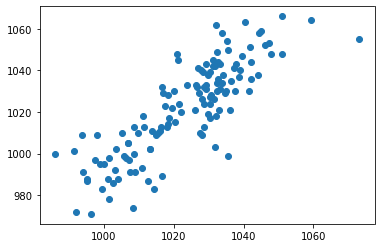

In [41]:
plt.plot(y_pred_rfr, y_valid, 'o')
plt.show()